# TFLite runtime test from MediaPipe

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/google-coral-micro-object-detection/blob/master/notebooks/tflite-runtime-test-object-detection.ipynb)

Perform post processing according to: https://github.com/google/mediapipe/blob/8609e5fae5c89bad69995e2ffeec62a9fefc0cb9/mediapipe/calculators/tensor/tensors_to_detections_calculator.cc#L787

```
Author: Shawn Hymel
Date: December 23, 2023
License: https://opensource.org/license/0bsd/
```

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade protobuf

Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import math
import os

from PIL import Image, ImageDraw
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/Users/Danny/Desktop/ICL/Thesis_Program/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/Danny/Desktop/ICL/Thesis_Program/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/Danny/Desktop/ICL/Thesis_Program/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/fram

In [8]:
# Settings
MODEL_PATH = "../firmware/object-detection-http/yolo_mcunet_model.tflite"
# MODEL_PATH = "yolo_mcunet_model.tflite"
# METADATA_PATH = "metadata.json"
METADATA_PATH = "metadata.json"
IMAGE_PATH = "../firmware/object-detection-http/examples/images/411_56081_108572_28_int8_160.rgb"
SCORE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.3

In [9]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(MODEL_PATH)
interpreter.allocate_tensors()

In [10]:
# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

print("====== Output =======")
print(output_details)
print("====== Input =======")
print(input_details)

# Get output details unique to MobileNetv2-SSD
# num_anchors = output_details[0]['shape'][1]
# num_locs = output_details[0]['shape'][2]
# num_classes = output_details[1]['shape'][2]

# Get output details unique to MCUNetYolo
num_anchors = 5
num_classes = 20
grid_size = 5
image_size = 160

# Get input quantization details (assume one input tensor)
input_type = input_details[0]['dtype']

if input_type is np.int8:
    input_scale = input_details[0]['quantization_parameters']['scales'][0]
    input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
elif input_type is np.uint8:
    input_scale = input_details[0]['quantization_parameters']['scales'][0]
    input_zero_point = input_details[0]['quantization_parameters']['zero_points'][0]
elif input_type is np.float32:
    input_scale = None
    input_zero_point = None
else:
    raise TypeError("Unsupported input tensor type")
    
# Get raw output quantization details (assume one tensor)
raw_output_type = output_details[0]['dtype']
if raw_output_type is np.int8:
    raw_output_scale = output_details[0]['quantization_parameters']['scales'][0]
    raw_output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
elif raw_output_type is np.uint8:
    raw_output_scale = output_details[0]['quantization_parameters']['scales'][0]
    raw_output_zero_point = output_details[0]['quantization_parameters']['zero_points'][0]
elif raw_output_type is np.float32:
    raw_output_scale = None
    raw_output_zero_point = None
else:
    raise TypeError("Unsupported output raw tensor type")

# Print details
print(f"Input shape: {input_shape}")
print(f"Number of anchors: {num_anchors}")
print(f"Number of classes: {num_classes}")
print(f"Input type: {input_type}")
print(f"Input scale: {input_scale}")
print(f"Input zero point: {input_zero_point}")
print(f"Output type: {raw_output_type}")
print(f"Output scale: {raw_output_scale}")
print(f"Output zero point: {raw_output_zero_point}")

====== Output =======
[{'name': 'classifier/layer1/det_head/conv/add', 'index': 222, 'shape': array([  1,   5,   5, 125], dtype=int32), 'shape_signature': array([ -1,   5,   5, 125], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.13262400031089783, 44), 'quantization_parameters': {'scales': array([0.132624], dtype=float32), 'zero_points': array([44], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
====== Input =======
[{'name': 'input', 'index': 0, 'shape': array([  1, 160, 160,   3], dtype=int32), 'shape_signature': array([ -1, 160, 160,   3], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003921568859368563, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Input shape: [  1 160 160   3]
Number of anchors: 5
Number of classes: 20
Input type: <class 'numpy.int8'>
Input scale: 0.003921568859368563
Input z

In [13]:
# Load and preprocess the JPEG image
# input_shape = input_details[0]['shape']
# image = Image.open(IMAGE_PATH)
# image = image.resize((input_shape[1], input_shape[2]))
# image_np = np.array(image, dtype=np.float32)

# image_np /= 255.0

# Load raw RGB file (int8, row-major, RGBRGB...) 
image_np = np.fromfile(IMAGE_PATH, dtype=np.int8)
expected = image_size * image_size * 3
if image_np.size != expected:
    raise ValueError(f"File size mismatch: got {image_np.size}, expected {expected}")
image_np = image_np.reshape(image_size, image_size, 3)   # NHWC


# Normalize or quantize the image (depending on expected input type)
if input_type is np.int8:
    quantized_image = np.round(image_np / input_scale + input_zero_point).astype(input_details[0]['dtype'])
    input_tensor = np.expand_dims(quantized_image, axis=0)
elif input_type is np.uint8:
    quantized_image = np.round(image_np / input_scale + input_zero_point).astype(input_details[0]['dtype'])
    input_tensor = np.expand_dims(quantized_image, axis=0)
elif input_type is np.float32:
    image = np.expand_dims(image, axis=0)
    image /= 255.0
else:
    raise TypeError("Unsupported input tensor type")

# Set the input tensor with the preprocessed image
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Run inference
interpreter.invoke()

# Get the output tensors
# scores = interpreter.get_tensor(output_details[1]['index'])
raw_boxes = interpreter.get_tensor(output_details[0]['index'])

# print(scores.shape)
print(raw_boxes.shape)

# Dequantized
raw_boxes = raw_output_scale * (raw_boxes.astype(np.float32) - raw_output_zero_point)

(1, 5, 5, 125)


In [14]:
# Import model metadata
with open(METADATA_PATH, 'r') as file:
    metadata = json.load(file)

# Parse metadata
custom_metadata = metadata['subgraph_metadata'][0]['custom_metadata'][0]
anchors = custom_metadata['data']['ssd_anchors_options']['fixed_anchors_schema']['anchors']
num_values_per_keypoint = custom_metadata['data']['tensors_decoding_options']['num_values_per_keypoint']
apply_exponential_on_box_size = custom_metadata['data']['tensors_decoding_options']['apply_exponential_on_box_size']
x_scale = custom_metadata['data']['tensors_decoding_options']['x_scale']
y_scale = custom_metadata['data']['tensors_decoding_options']['y_scale']
w_scale = custom_metadata['data']['tensors_decoding_options']['w_scale']
h_scale = custom_metadata['data']['tensors_decoding_options']['h_scale']

# Print metadata
print(f"Number of anchors: {len(anchors)}")
print(f"Values per keypoint: {num_values_per_keypoint}")
print(f"Apply exponential scaling: {apply_exponential_on_box_size}")
print(f"X scale: {x_scale}")
print(f"Y scale: {y_scale}")
print(f"Width scale: {w_scale}")
print(f"Height scale: {h_scale}")

Number of anchors: 5
Values per keypoint: 4
Apply exponential scaling: True
X scale: 10.0
Y scale: 10.0
Width scale: 5.0
Height scale: 5.0


In [15]:
def sigmoid_custom(x):
    # This implementation is numerically stable, mirroring the C++ version
    return np.where(x >= 0, 1.0 / (1.0 + np.exp(-x)), np.exp(x) / (1.0 + np.exp(x)))


In [21]:
# Decode bounding boxes
bboxes = []
# Reshape raw output to [B, S, S, A, 5+C]
raw_boxes = raw_boxes.reshape((1, grid_size, grid_size, num_anchors, 5 + num_classes))
print(raw_boxes.shape)

# Extract components
tx = raw_boxes[..., 0]
ty = raw_boxes[..., 1]
tw = raw_boxes[..., 2]
th = raw_boxes[..., 3]
obj_logit = raw_boxes[..., 4]
cls_logits = raw_boxes[..., 5:]

# Apply activation functions
sig_tx = sigmoid_custom(tx) # Sigmoid for tx
sig_ty = sigmoid_custom(ty)  # Sigmoid for ty
if apply_exponential_on_box_size:
    exp_tw = np.exp(tw)  # Exponential for tw
    exp_th = np.exp(th)  # Exponential for th
else:
    exp_tw = tw
    exp_th = th
    
obj = sigmoid_custom(obj_logit)  # Sigmoid for objectness
# Use a numerically stable softmax to prevent overflow
# cls_probs = np.exp(cls_logits) / np.sum(np.exp(cls_logits), axis=-1, keepdims=True)
cls_logits_shifted = cls_logits - np.max(cls_logits, axis=-1, keepdims=True)
cls_probs = np.exp(cls_logits_shifted) / np.sum(np.exp(cls_logits_shifted), axis=-1, keepdims=True)

# Decode each grid cell
for i in range(grid_size):  # Grid rows
    for j in range(grid_size):  # Grid columns
        for a, anchor in enumerate(anchors):
            
            # Compute normalized cx, cy, w, h
            cx = (j + sig_tx[0, i, j, a]) / grid_size
            cy = (i + sig_ty[0, i, j, a]) / grid_size
            bw = (anchor['width'] * exp_tw[0, i, j, a]) / grid_size
            bh = (anchor['height'] * exp_th[0, i, j, a]) / grid_size

            # Convert to pixel coordinates
            x_min = (cx - bw / 2.0) * image_size
            y_min = (cy - bh / 2.0) * image_size
            x_max = (cx + bw / 2.0) * image_size
            y_max = (cy + bh / 2.0) * image_size

            # Compute final confidence
            best_cls_prob = np.max(cls_probs[0, i, j, a])
            best_cls_id = np.argmax(cls_probs[0, i, j, a])
            final_conf = obj[0, i, j, a] * best_cls_prob

            print([x_min, y_min, x_max, y_max, final_conf, best_cls_id])
            
            # Filter by confidence threshold
            if final_conf > SCORE_THRESHOLD:
                bboxes.append([x_min, y_min, x_max, y_max, final_conf, best_cls_id])

# Print decoded bounding boxes
for bbox in bboxes:
    print(f"Bounding box: {bbox}")
    

(1, 5, 5, 5, 25)
[np.float64(9.464390171695637), np.float64(3.923649880539611), np.float64(18.316350552815635), np.float64(17.83885220763291), np.float64(0.03229418607385746), np.int64(14)]
[np.float64(5.745595726840536), np.float64(7.434429100166575), np.float64(24.135525127364026), np.float64(36.665625079224434), np.float64(0.02893252308874559), np.int64(6)]
[np.float64(5.495674928850338), np.float64(-16.997079300098207), np.float64(30.723584346638386), np.float64(48.997079300098214), np.float64(0.0025779492968513546), np.int64(15)]
[np.float64(-6.018239087521351), np.float64(-16.094777864155176), np.float64(33.79897981203263), np.float64(52.3140371396439), np.float64(0.0008611470564191084), np.int64(18)]
[np.float64(-22.935324970866148), np.float64(-14.943629740291659), np.float64(65.17282288269364), np.float64(46.94362974029167), np.float64(0.0004833430985884873), np.int64(18)]
[np.float64(45.05595431009504), np.float64(12.41515673664098), np.float64(55.163304965393685), np.float64

In [17]:
# # Change threshold to quantized value if needed
# # if scores_type is np.uint8:
# #    score_threshold = np.round(SCORE_THRESHOLD / scores_scale) + scores_zero_point
# # elif scores_type is np.float32:
# #    score_threshold = SCORE_THRESHOLD
# # else:
# #     raise TypeError("Unsupported scores output tensor type")

# # Go through all anchor points and create a list of bounding boxes
# bboxes = []
# for i in range(num_anchors):
#     for c, s in enumerate(scores[0, i, :]):

#         # Only keep boxes above a particular score threshold
#         if c > 0 and s >= score_threshold:

#             # Assume raw box output tensor is given as YXHW (MobileNet SSD)
#             # TODO: Handle different output tensor formats
#             y_center = raw_boxes[0, i, 0]
#             x_center = raw_boxes[0, i, 1]
#             h = raw_boxes[0, i, 2]
#             w = raw_boxes[0, i, 3]

#             # De-quantize if needed
#             if locs_type is np.uint8:
#                 y_center = (y_center - locs_zero_point) * locs_scale
#                 x_center = (x_center - locs_zero_point) * locs_scale
#                 h = (h - locs_zero_point) * locs_scale
#                 w = (w - locs_zero_point) * locs_scale
#             elif locs_type is np.float32:
#                 pass
#             else:
#                 raise TypeError("Unsupported location output type type")

#             # Scale
#             x_center = x_center / x_scale * anchors[i]['width'] + anchors[i]['x_center']
#             y_center = y_center / y_scale * anchors[i]['height'] + anchors[i]['y_center']
#             if apply_exponential_on_box_size:
#                 w = math.exp(w / w_scale) * anchors[i]['width']
#                 h = math.exp(h / h_scale) * anchors[i]['height']
#             else:
#                 w = w / w_scale * anchors[i]['width']
#                 h = h / h_scale * anchors[i]['height']

#             # Assume no keypoint detections in MobileNet SSD
#             # TODO: handle keypoints

#             # Determine min/max coordinates
#             x_min = x_center - w / 2.0
#             y_min = y_center - h / 2.0
#             x_max = x_center + w / 2.0
#             y_max = y_center + h / 2.0


#             # Clamp values
#             x_min = max(0, min(1.0, x_min))
#             y_min = max(0, min(1.0, y_min))
#             x_max = max(0, min(1.0, x_max))
#             y_max = max(0, min(1.0, y_max))

#             # Append bounding box
#             bboxes.append([c, s, x_min, y_min, x_max, y_max])

# # Print boxes
# for bbox in bboxes:
#     print(bbox)

In [18]:
# [x_min, y_min, x_max, y_max, final_conf, best_cls_id]

def calculate_iou(box1, box2):

    # Coordinates of the intersection box
    x_min_inter = max(box1[0], box2[0]) 
    y_min_inter = max(box1[1], box2[1])  
    x_max_inter = min(box1[2], box2[2]) 
    y_max_inter = min(box1[3], box2[3]) 

    # Width and height of the intersection box
    width_inter = max(0, x_max_inter - x_min_inter)
    height_inter = max(0, y_max_inter - y_min_inter)

    # Area of intersection
    area_inter = width_inter * height_inter

    # Areas of the input boxes
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Area of union
    area_union = area_box1 + area_box2 - area_inter

    # Intersection over Union
    iou = area_inter / area_union if area_union != 0 else 0

    return iou


In [19]:
# Non-maximum suppression
# https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c
bboxes_nms = []
for i in range(len(bboxes)):
    discard = False
    for j in range(len(bboxes)):

        # Do not compare bboxes with different classes
        if bboxes[i][5] != bboxes[j][5]:
            continue

        # If j box is higher score than i and above IOU threshold, mark to discard
        iou = calculate_iou(bboxes[i], bboxes[j])
        if iou > IOU_THRESHOLD:
            if bboxes[j][4] > bboxes[i][4]:
                discard = True

    # Only keep highest scoring box
    if not discard:
        bboxes_nms.append(bboxes[i])

# Print boxes
for bbox in bboxes_nms:
    print(bbox)

NameError: name 'image' is not defined

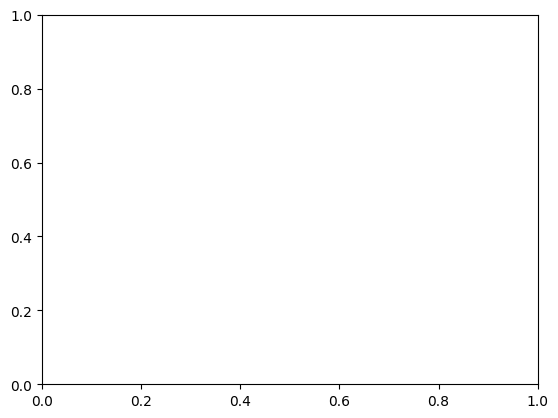

In [20]:
# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Iterate through bounding boxes in bbox_list and draw them
for bbox in bboxes_nms:
    print(bbox)
    class_id, score, xmin, ymin, xmax, ymax = bbox
    left = int(xmin + 0.05)
    top = int(ymin + 0.05)
    width = int((xmax - xmin) + 0.05)
    height = int((ymax - ymin) + 0.05)

    # Create a Rectangle patch
    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

# Show the image with bounding boxes
plt.show()